# Forecasting - Facebook Prophet

In [54]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [55]:
from fbprophet import Prophet 

In [56]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [58]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [59]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [60]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

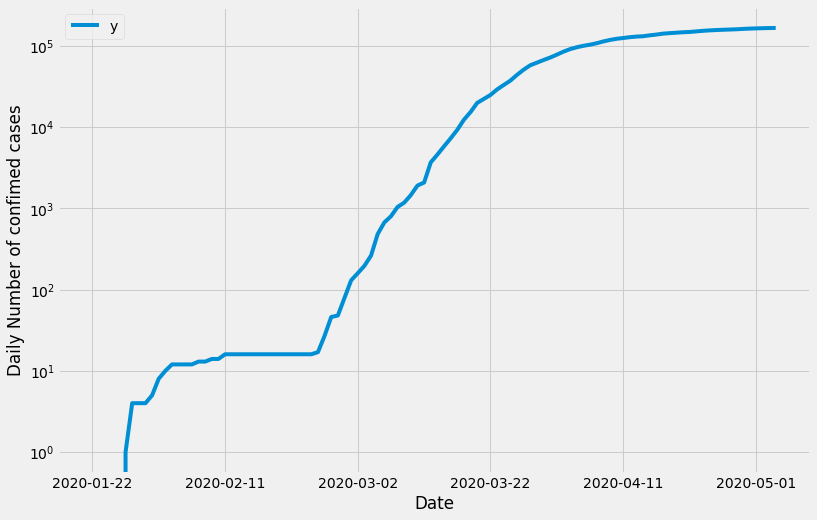

In [61]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [62]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [63]:
df['cap'] = 1000000
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
106,2020-05-07,1000000.0
107,2020-05-08,1000000.0
108,2020-05-09,1000000.0
109,2020-05-10,1000000.0
110,2020-05-11,1000000.0


In [65]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

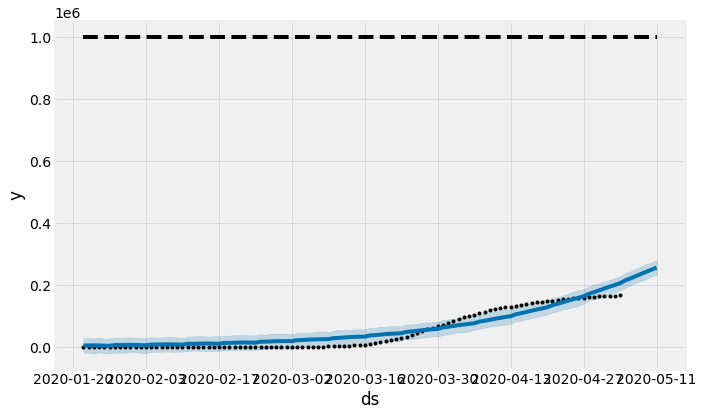

In [66]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [67]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [68]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,4007.767525,1000000.0,-19042.263407,27695.563709,4007.767525,4007.767525,437.196363,437.196363,437.196363,437.196363,437.196363,437.196363,0.0,0.0,0.0,4444.963888
1,2020-01-23,4172.932579,1000000.0,-19129.987316,29184.536448,4172.932579,4172.932579,477.259781,477.259781,477.259781,477.259781,477.259781,477.259781,0.0,0.0,0.0,4650.192360
2,2020-01-24,4344.874595,1000000.0,-21343.701609,27503.293904,4344.874595,4344.874595,557.448972,557.448972,557.448972,557.448972,557.448972,557.448972,0.0,0.0,0.0,4902.323567
3,2020-01-25,4523.869146,1000000.0,-18094.670324,29308.818244,4523.869146,4523.869146,46.275207,46.275207,46.275207,46.275207,46.275207,46.275207,0.0,0.0,0.0,4570.144353
4,2020-01-26,4710.202800,1000000.0,-20237.604287,25844.143896,4710.202800,4710.202800,-724.201263,-724.201263,-724.201263,-724.201263,-724.201263,-724.201263,0.0,0.0,0.0,3986.001537


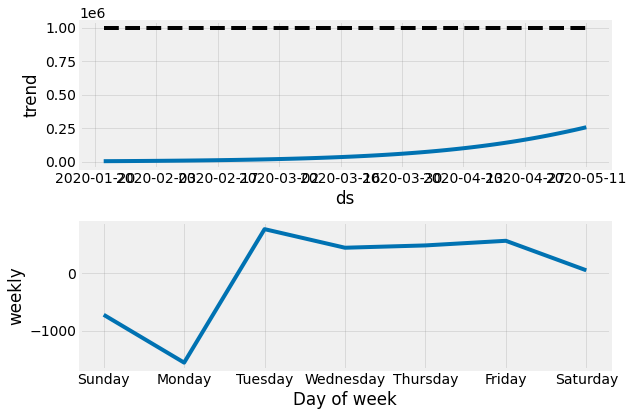

In [69]:
my_model.plot_components(forecast);

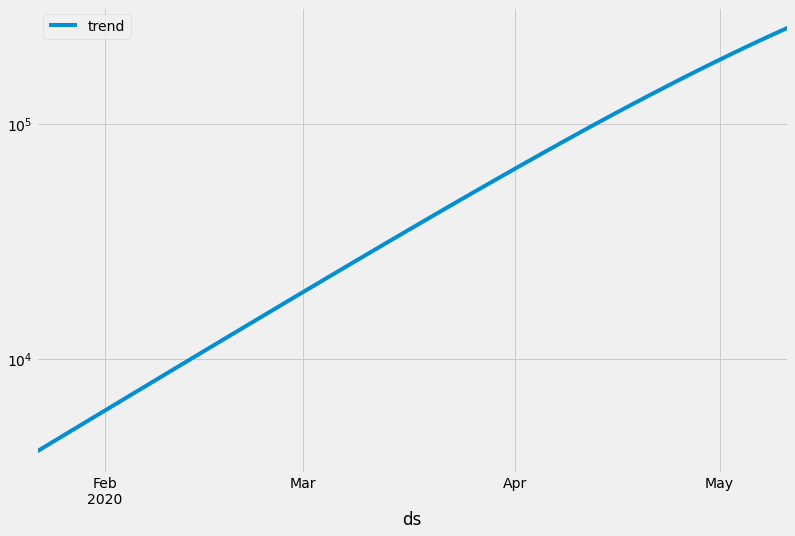

In [70]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross Validation

In [71]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='30 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 67 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-04-27 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [72]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.027637,17.974884,25.630364,16,2020-02-21
1,2020-02-23,23.462766,19.612465,27.092623,16,2020-02-21
2,2020-02-24,24.935360,20.908195,28.806218,16,2020-02-21
3,2020-02-25,26.947453,23.027982,30.743115,17,2020-02-21
4,2020-02-26,26.785522,23.007118,30.761074,27,2020-02-21


In [73]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.027637,17.974884,25.630364,16,2020-02-21
1,2020-02-23,23.462766,19.612465,27.092623,16,2020-02-21
2,2020-02-24,24.935360,20.908195,28.806218,16,2020-02-21
3,2020-02-25,26.947453,23.027982,30.743115,17,2020-02-21
4,2020-02-26,26.785522,23.007118,30.761074,27,2020-02-21
5,2020-02-27,27.714559,23.870264,31.727023,46,2020-02-21
6,2020-02-28,29.094275,25.205107,33.187568,48,2020-02-21
7,2020-02-23,22.406158,18.288742,26.441994,16,2020-02-22
8,2020-02-24,23.786702,19.903877,27.803304,16,2020-02-22
9,2020-02-25,25.699916,21.706848,29.548467,17,2020-02-22


In [74]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [75]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,4.671373e+08,21613.359072,14130.990153,0.270878,0.207366,0.029851
1,2 days,7.127686e+08,26697.725739,18240.280711,0.330919,0.297474,0.029851
2,3 days,1.053656e+09,32460.067947,22992.766908,0.390434,0.361735,0.044776
3,4 days,1.520438e+09,38992.788849,28463.593110,0.448560,0.416279,0.029851
4,5 days,2.151289e+09,46381.988711,34752.781284,0.511288,0.486062,0.029851
5,6 days,2.997245e+09,54747.099930,41962.477201,0.593704,0.574573,0.014925
6,7 days,4.125991e+09,64233.876170,50203.391014,0.677889,0.685521,0.014925


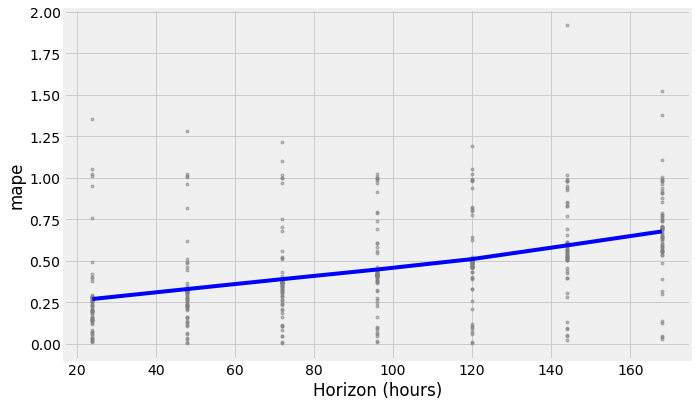

In [76]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonal-plot

### gives a good understanding for the under and over estimation w.r.t. magnitude

In [77]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [78]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
440,2020-04-30,254660.140137,237987.044481,271650.594080,163009,2020-04-23,7 days
447,2020-05-01,256183.816779,239343.288416,274043.949485,164077,2020-04-24,7 days
454,2020-05-02,256967.325825,237793.209747,275045.163391,164967,2020-04-25,7 days
461,2020-05-03,257869.537749,239666.128224,276886.081827,165664,2020-04-26,7 days
468,2020-05-04,258229.126490,237861.951420,278479.634163,166152,2020-04-27,7 days


In [79]:
type(df_cv['horizon'][0])


pandas._libs.tslibs.timedeltas.Timedelta

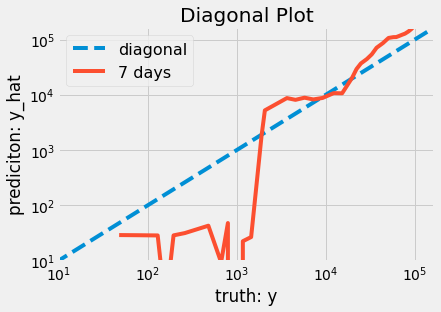

In [80]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

* Example trivial forecast, prediciton 7 days into the future

In [81]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [82]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean

* An other standard forecast is the exponentially-weighted moving average, see pandas.ewma

In [83]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [84]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 306.84511176103734


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
